# Kurtosis of Toy Data

## Load data

In [1]:
import scipy.io as sio

data = sio.loadmat("distrib.mat")

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue May 15 10:24:27 2007',
 '__version__': '1.0',
 '__globals__': [],
 'normal': array([[4.4866489 , 5.73481949, 5.74683601, ..., 6.40134747, 7.56532163,
         6.08646673],
        [3.68928424, 6.97120081, 7.02406635, ..., 8.58341748, 7.36761386,
         5.59494611]]),
 'laplacian': array([[5.05043591, 5.40896579, 5.73751987, ..., 3.94898749, 4.29575624,
         5.46787394],
        [4.38647042, 5.73348575, 4.46914584, ..., 5.12949728, 4.87544004,
         5.10960572]]),
 'uniform': array([[1.41456199, 1.816727  , 1.63854879, ..., 2.40895133, 2.00678937,
         2.19639833],
        [1.35534763, 2.04092264, 2.29032188, ..., 1.86577962, 2.89931084,
         1.54884027]])}

In [5]:
data["normal"].shape

(2, 10000)

In [26]:
import matplotlib.pyplot as plt

def scatter_plot(X):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(x=X[0], y=X[1])

## Apply mixing matrix

In [27]:
import numpy as np

A = np.array([[4, 3], [2, 1]])

In [28]:
def mix_sources(S, A=A):
    return A @ S

In [29]:
mix_sources(data["normal"])

array([[29.01444831, 43.85288038, 44.0595431 , ..., 51.35564234,
        52.36412812, 41.13070524],
       [12.66258203, 18.44083979, 18.51773837, ..., 21.38611243,
        22.49825713, 17.76787957]])

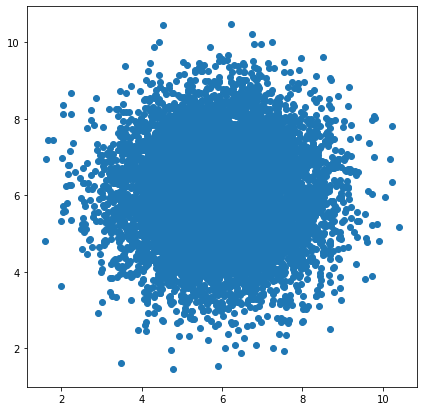

In [30]:
scatter_plot(data["normal"])

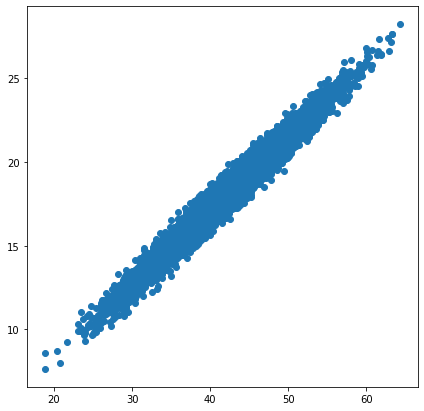

In [106]:
scatter_plot(mix_sources(data["normal"]))

## Center data

In [103]:
def center_mixtures(X):
    mean = X.mean(axis=1)
    return X - mean[:, np.newaxis]

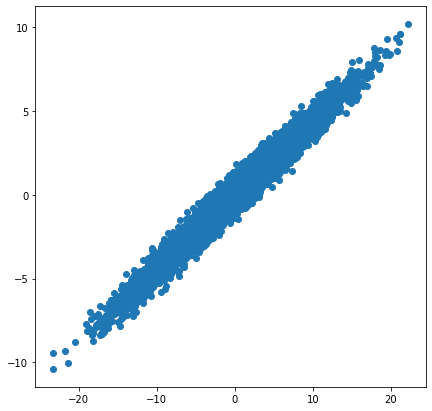

In [104]:
scatter_plot(center_mixtures(mix_sources(data["normal"])))

## Decorrelate mixtures

In [31]:
from numpy.linalg import eig

def decorrelate_mixtures(X):
    C = np.cov(X)
    e, M = eig(C)
    sort_perm = e.argsort()[::-1]
    e = e[sort_perm]
    M = M[:,sort_perm]
    U = M.T @ X
    return U

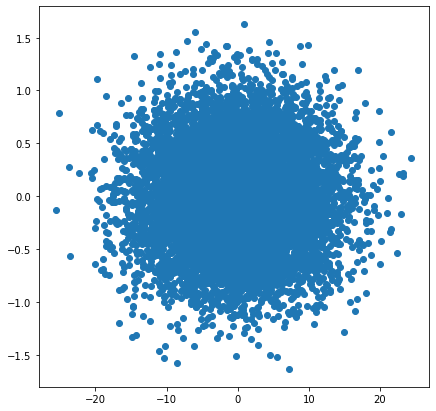

In [105]:
scatter_plot(decorrelate_mixtures(center_mixtures(mix_sources(data["normal"]))))

## Scale to unit variance

In [33]:
np.cov(decorrelate_mixtures(data["normal"]))

array([[1.52337160e+00, 2.49836266e-16],
       [2.49836266e-16, 1.50865291e+00]])

In [37]:
def scale_to_unit_variance(U):
    C = np.cov(U)
    variances = np.diag(C)
    std_recip = np.reciprocal(np.sqrt(variances))
    Lambda = np.diag(std_recip)
    V = Lambda @ U
    return V

array([[ 1.00000000e+00, -1.15296533e-15],
       [-1.15296533e-15,  1.00000000e+00]])

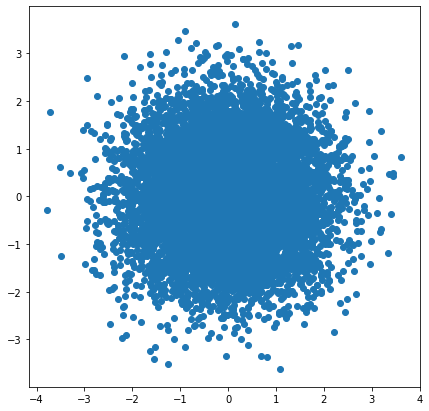

In [108]:
scatter_plot(scale_to_unit_variance(decorrelate_mixtures(center_mixtures(mix_sources(data["normal"])))))
np.cov(scale_to_unit_variance(decorrelate_mixtures(center_mixtures(mix_sources(data["normal"])))))

In [90]:
def whiten(X):
    return scale_to_unit_variance(decorrelate_mixtures(center_mixtures(X)))

## Rotate whitened mixtures

In [41]:
from numpy import sin, cos

def rotate_mixtures(V, theta):
    R = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    return R @ V

In [47]:
import math

thetas = np.linspace(0, 2 * math.pi, 100)
thetas

array([0.        , 0.06346652, 0.12693304, 0.19039955, 0.25386607,
       0.31733259, 0.38079911, 0.44426563, 0.50773215, 0.57119866,
       0.63466518, 0.6981317 , 0.76159822, 0.82506474, 0.88853126,
       0.95199777, 1.01546429, 1.07893081, 1.14239733, 1.20586385,
       1.26933037, 1.33279688, 1.3962634 , 1.45972992, 1.52319644,
       1.58666296, 1.65012947, 1.71359599, 1.77706251, 1.84052903,
       1.90399555, 1.96746207, 2.03092858, 2.0943951 , 2.15786162,
       2.22132814, 2.28479466, 2.34826118, 2.41172769, 2.47519421,
       2.53866073, 2.60212725, 2.66559377, 2.72906028, 2.7925268 ,
       2.85599332, 2.91945984, 2.98292636, 3.04639288, 3.10985939,
       3.17332591, 3.23679243, 3.30025895, 3.36372547, 3.42719199,
       3.4906585 , 3.55412502, 3.61759154, 3.68105806, 3.74452458,
       3.8079911 , 3.87145761, 3.93492413, 3.99839065, 4.06185717,
       4.12532369, 4.1887902 , 4.25225672, 4.31572324, 4.37918976,
       4.44265628, 4.5061228 , 4.56958931, 4.63305583, 4.69652

In [91]:
from scipy import stats

def kurtosis(X):
    return stats.moment(X, moment=4, axis=1) - 3

In [110]:
kurtosis(whiten(mix_sources(data["normal"])))

array([-0.03652575, -0.07123837])

In [109]:
stats.kurtosis(whiten(mix_sources(data["normal"])), axis=1)

array([-0.03593296, -0.07065253])

## Find min and max kurtosis for first dimension

In [120]:
def kurtosises_for_mixture_rotations(V, thetas=thetas):
    kurtosises = np.array([kurtosis(rotate_mixtures(V, theta)) for theta in thetas]).T
    return kurtosises

def find_min_max_kurtosis_rotations(V, thetas=thetas): 
    kurtosises = kurtosises_for_mixture_rotations(V, thetas)
    min_kurt = np.argmin(kurtosises[0])
    max_kurt = np.argmax(kurtosises[0])
    return (thetas[min_kurt], thetas[max_kurt])

In [121]:
find_min_max_kurtosis_rotations(whiten(mix_sources(data["normal"])))

(1.4597299198498028, 2.4117276936648917)

## Plot data sets after each step

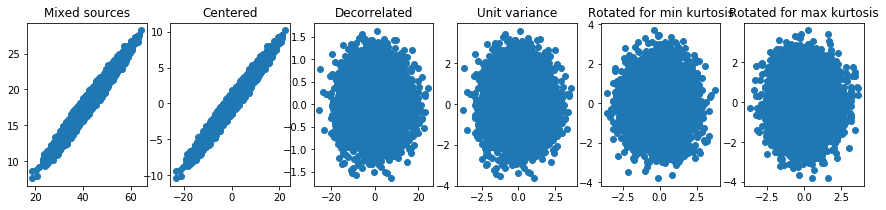

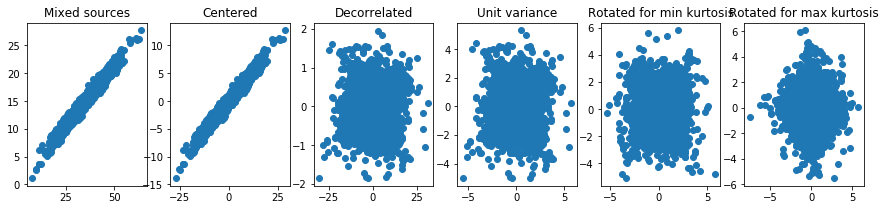

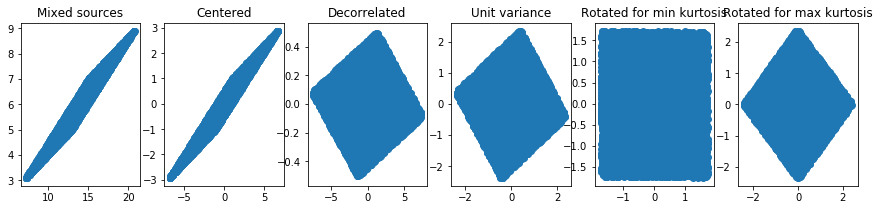

In [122]:
for S in [data["normal"], data["laplacian"], data["uniform"]]:
    fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(15, 3))
    X = mix_sources(S)
    X_c = center_mixtures(X)
    U = decorrelate_mixtures(X_c)
    V = scale_to_unit_variance(U)
    min_kurt_rotation, max_kurt_rotation = find_min_max_kurtosis_rotations(V)
    V_min = rotate_mixtures(V, min_kurt_rotation)
    V_max = rotate_mixtures(V, max_kurt_rotation)

    ax[0].set_title("Mixed sources")
    ax[0].scatter(X[0], X[1])
    
    ax[1].set_title("Centered")
    ax[1].scatter(X_c[0], X_c[1])
    
    ax[2].set_title("Decorrelated")
    ax[2].scatter(U[0], U[1])
    
    ax[3].set_title("Unit variance")
    ax[3].scatter(V[0], V[1])
    
    ax[4].set_title("Rotated for min kurtosis")
    ax[4].scatter(V_min[0], V_min[1])
    ax[5].set_title("Rotated for max kurtosis")
    ax[5].scatter(V_max[0], V_max[1])

## Plot kurtosis for each dimension as function of $\theta$

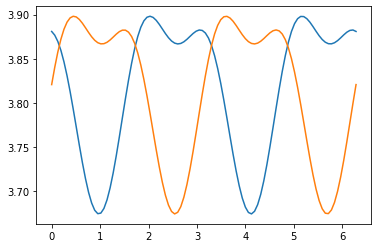

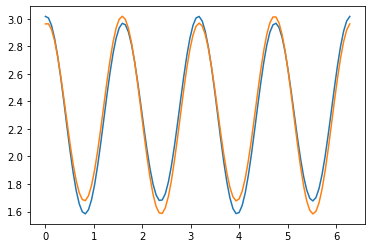

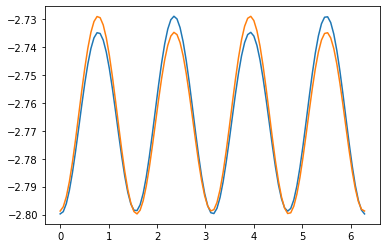

In [127]:
for S in [data["normal"], data["laplacian"], data["uniform"]]:
    kurtosises = kurtosises_for_mixture_rotations(S, thetas)
    fig, ax = plt.subplots()
    ax.plot(thetas, kurtosises[0])
    ax.plot(thetas, kurtosises[1])